## Relation of Variance and Predictive Error CPL
Author: Clara Hoffmann

In [1]:
# load packages
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
from helpers import (Fy, find_closest_element, error_vs_variance)
from density_predictor_class import density_predictor

In [2]:
# read in val data
B_zeta = np.load('../../../../data/commaai/extracted_coefficients/copula_cpl/Bzeta/B_zeta_val.npy')
B_zeta = B_zeta.reshape(B_zeta.shape[0], B_zeta.shape[2])
beta = np.genfromtxt('../../../../data/commaai/extracted_coefficients/copula_cpl/beta/beta.csv', delimiter = ',')
true_y = np.load('../../../../data/commaai/extracted_coefficients/copula_cpl/Bzeta/labels_val.npy')

density_path = '../../../../data/commaai/density/gaussian_density_filtered.csv'
density = pd.read_csv(density_path)

no_points = 1000
# grid for variance
grid = np.linspace(0,500,1000)

In [3]:
# get predictive densities
dens = density_predictor(B_zeta, true_y, density, no_points)
result_va_ridge = dens.get_density('va_ridge')
#result_hmc_ridge = dens.get_density('hmc_ridge')
result_va_horse = dens.get_density('va_horseshoe')
#result_hmc_horse = dens.get_density('hmc_horseshoe')

  0%|          | 16/10472 [00:00<01:07, 153.78it/s]

computing densities for each observation


 14%|█▍        | 1483/10472 [00:00<00:00, 14822.13it/s]

computing mean prediction for each observation


 13%|█▎        | 1327/10472 [00:00<00:00, 13268.37it/s]

computing variance prediction for each observation


100%|██████████| 10472/10472 [00:00<00:00, 13679.53it/s]


In [4]:
# save densities for later use
df = pd.DataFrame({'va_ridge' : result_va_ridge['variance prediction'],
                 'hmc_ridge' : result_hmc_ridge['variance prediction'],
                 'va_horse' : result_va_horse['variance prediction'],
                 'hmc_horse' : result_hmc_horse['variance prediction']})
df.to_csv('../../../../data/commaai/predictions/cpl/densities.csv')

NameError: name 'result_hmc_ridge' is not defined

In [4]:
mc_preds = np.append(np.load('../../../../data/commaai/predictions/mc_dropout/mc_preds_2.npy'),
          np.load('../../../../data/commaai/predictions/mc_dropout/mc_preds_1.npy')).reshape(-1,1000)
mc_var = np.std(mc_preds, axis = 1)**2
mc_mean = np.mean(mc_preds, axis = 1)
results_mc = pd.DataFrame({'mean prediction': mc_mean.reshape(-1),
                          'variance prediction': mc_var.reshape(-1)})

In [5]:
mdn_preds = np.load('../../../../data/commaai/predictions/mdn/cpl/samples.npy')
mdn_var = np.std(mdn_preds, axis = 1)**2
mdn_mean = np.mean(mdn_preds, axis = 1)
results_mdn = pd.DataFrame({'mean prediction': mdn_mean.reshape(-1),
                          'variance prediction': mdn_var.reshape(-1)})

In [6]:
# mse of predictions given grid (= variance) value
er_conf_va_ridge = error_vs_variance(result_va_ridge, grid, true_y)
#er_conf_hmc_ridge = error_vs_variance(result_hmc_ridge, grid, true_y)
er_conf_va_horse = error_vs_variance(result_va_horse, grid, true_y)
#er_conf_hmc_horse = error_vs_variance(result_hmc_horse, grid, true_y)
er_conf_mc = error_vs_variance(results_mc, grid, true_y)
er_conf_mdn = error_vs_variance(results_mdn, grid, true_y)

In [7]:
plt.rcParams.update({'font.size': 14})

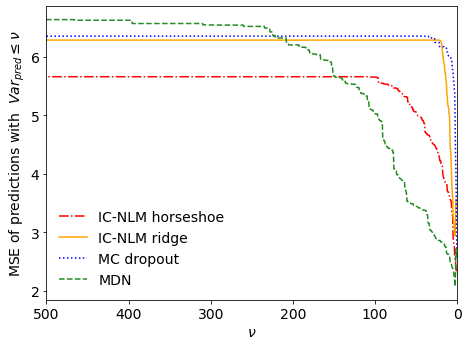

In [9]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)
#plt.plot(grid, er_conf_hmc_horse, label = 'HMC/Horseshoe', color = 'darkred', linestyle = 'dashed')
ax.plot(grid, er_conf_va_horse, label = 'IC-NLM horseshoe', color = 'red', linestyle = '-.')
ax.plot(grid, er_conf_va_ridge, label = 'IC-NLM ridge', color = 'orange')
#plt.plot(grid, er_conf_hmc_ridge, label = 'HMC/Ridge', color = 'darkorange')
ax.plot(grid, er_conf_mc, label = 'MC dropout', color = 'blue', linestyle = ':')
ax.plot(grid, er_conf_mdn, label = 'MDN', color = 'forestgreen', linestyle = '--')
ax.legend(framealpha=0.0)
ax.set_xlabel(r'$\nu$')
ax.set_ylabel(r'MSE of predictions with  $Var_{pred} \leq \nu$')
ax.set_xlim(0,500)
plt.tight_layout()
plt.gca().invert_xaxis()
fig.set_size_inches(8, 6)
figure = plt.gcf()
figure.set_size_inches(8, 6)
plt.savefig('error_vs_confidence_cpl.png', dpi=100, bbox_inches='tight')
# good! mse increases with higher variance

In [ ]:
plt.scatter(result_va_horse['mean prediction'], result_va_horse['variance prediction'], alpha = 0.2,color = 'darkred', label = 'HMC/VA Horseshoe')
plt.scatter(result_hmc_ridge['mean prediction'], result_hmc_ridge['variance prediction'], alpha = 0.2, color = 'orange', label = 'HMC/VA Ridge')
plt.scatter(results_mc['mean prediction'], results_mc['variance prediction'], alpha = 0.2, color = 'blue', label = 'MC-Dropout')
plt.scatter(results_mdn['mean prediction'], results_mdn['variance prediction'], alpha = 0.2, color = 'forestgreen', label = 'MC-Dropout')
plt.legend()
plt.legend(framealpha=0.0)
plt.ylim(-5,200)
plt.xlabel('steering angle in degrees')
plt.ylabel('predicted variance')
plt.savefig('mean_vs_var_cpl.png')